# Coding Discussion 06
### Ella Zhang

## Preparation

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Data
Below is a dataset that records attribution on housing characteristics for D.C. residential properties.
#### Attribute Information
* **OBJECTID:** internal feature number 
* **SSL:** square suffix and lot of property
* **BATHRM:** number of bathrooms
* **HF_BATHRM:** number of half bathrooms
* **HEAT:** heat type code
* **HEAT_D:** heating type description
* **AC:** air conditioning in residence
* **NUM_UNITS:** number of units
* **ROOMS:** number of rooms
* **BEDRM:** number of bedrooms
* **AYB:** the earliest time the main portion of the building was built
* **YR_RMDL:** last year residence was remodeled
* **EYB:** the year an improvement was built more recent than actual year built
* **STORIES:** number of stories in primary dwelling
* **SALEDATE:** date of most recent sale
* **QUALIFIED:** an indicator to reflect if a sale is representative of market value
* **SALE_NUM:** sale number (always 1 to get most recent sale)
* **GBA:** gross building area in square feet
* **BLDG_NUM:** building number on property (1 is primary dwelling)
* **STYLE:** style code
* **STYLE_D:** style description
* **STRUCT:** structure code
* **STRUCT_D:** structure description
* **GRADE:** grade code
* **GRADE_D:** grade description
* **CNDTN:** condition code
* **CNDTN_D:** condition description
* **EXTWALL:** exterior wall code
* **EXTWALL_D:** exterior wall description
* **ROOF:** roof type code
* **ROOF_D:** roof type description
* **INTWALL:** interior wall code
* **INTWALL_D:** interior wall description
* **KITCHENS:** number of kitchens
* **FIREPLACES:** number of fireplaces
* **USECODE:** property use code
* **LANDAREA:** land area of property in square feet
* **GIS_LAST_MOD_DTTM:** last modified date
* **LN_PRICE:** log of price

In [2]:
# Read in the training dataset
train = pd.read_csv("../train_data.csv")
train.shape

(43590, 39)

In [3]:
# Look at the head of the data
train.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


<AxesSubplot:>

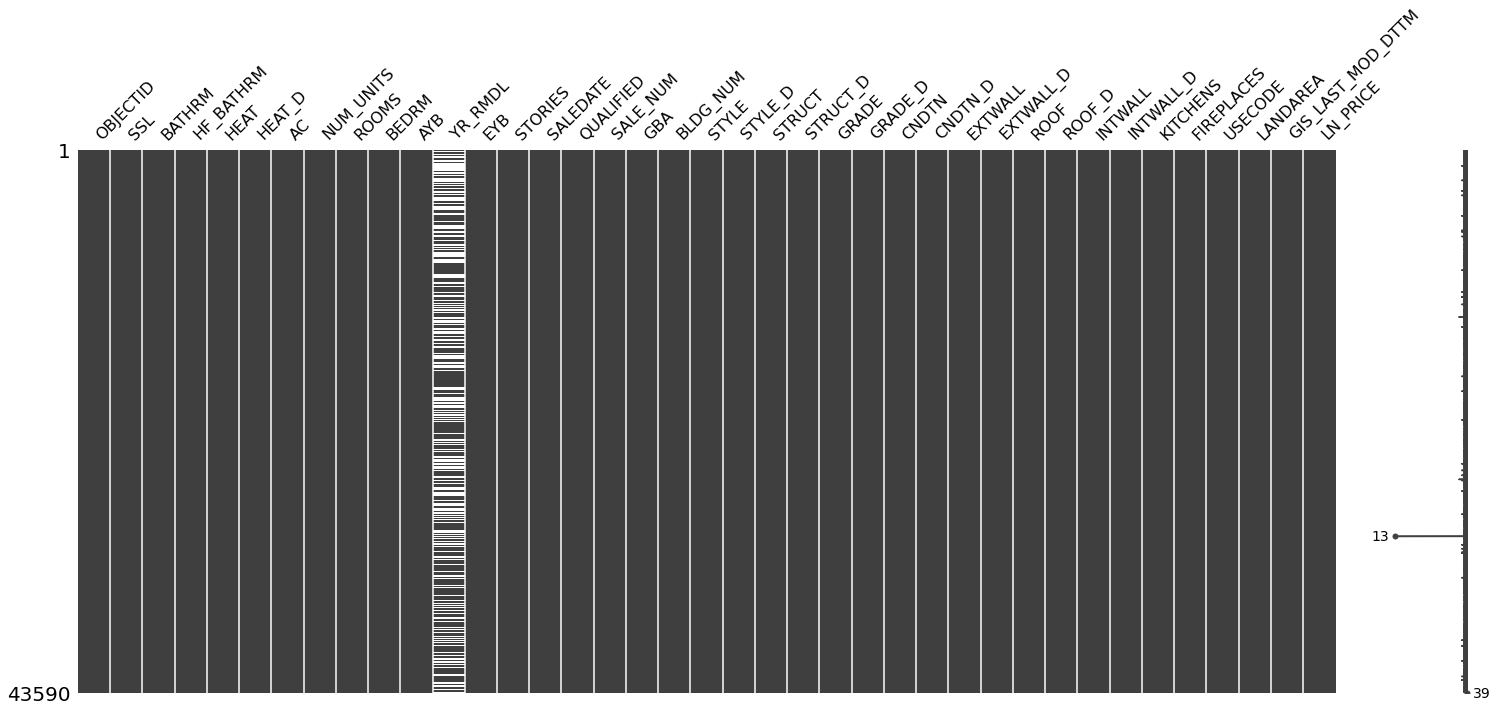

In [4]:
# Look at missingness in the data
miss.matrix(train)

In [5]:
# Drop observations where logged price is zero
train = train[train["LN_PRICE"] != 0]

# Drop observations with NA values
train.dropna(inplace = True)

In [6]:
# Subset the training data to chosen features
train = train[['BATHRM','AC','ROOMS','SALEDATE','GBA','CNDTN','FIREPLACES','LN_PRICE']]

# Check the data type of each column
train.dtypes

BATHRM        float64
AC             object
ROOMS         float64
SALEDATE       object
GBA             int64
CNDTN         float64
FIREPLACES    float64
LN_PRICE      float64
dtype: object

In [7]:
# Change Y/N in column AC to 1/0
train['AC'] = train.AC.map(dict(Y=1,N=0))
train.dropna(subset=['AC'],inplace=True)

# Convert column SALEDATE to datetime and keep only year
train['SALEDATE'] = pd.to_datetime(train['SALEDATE']).dt.year

# Generate descriptive statistics
train.describe().round(1)

,BATHRM,AC,ROOMS,SALEDATE,GBA,CNDTN,FIREPLACES,LN_PRICE
count,24991.0,24991.0,24991.0,24991.0,24991.0,24991.0,24991.0,24991.0
mean,2.4,0.8,7.6,2010.0,1787.6,3.9,0.8,13.2
std,1.1,0.4,2.3,6.4,863.0,0.6,1.0,0.8
min,0.0,0.0,0.0,1986.0,407.0,1.0,0.0,2.3
25%,2.0,1.0,6.0,2006.0,1240.0,3.0,0.0,12.7
50%,2.0,1.0,7.0,2012.0,1560.0,4.0,1.0,13.2
75%,3.0,1.0,9.0,2015.0,2090.0,4.0,1.0,13.6
max,11.0,1.0,30.0,2018.0,15902.0,6.0,13.0,16.9


In [8]:
# Calculate the interquartile range (IQR)
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

# Subset the column with continuous data
IQR_col = ['BATHRM','ROOMS','SALEDATE','GBA','FIREPLACES','LN_PRICE']

# Drop the outliers
train = train[~((train[IQR_col] < (Q1 - 1.5 * IQR))|
                (train[IQR_col] > (Q3 + 1.5 * IQR)))
              .any(axis=1)]

# Generate descriptive statistics
train.describe().round(1)

,BATHRM,AC,ROOMS,SALEDATE,GBA,CNDTN,FIREPLACES,LN_PRICE
count,21973.0,21973.0,21973.0,21973.0,21973.0,21973.0,21973.0,21973.0
mean,2.2,0.8,7.2,2010.3,1606.4,3.9,0.6,13.1
std,0.9,0.4,1.7,6.1,549.2,0.6,0.7,0.7
min,1.0,0.0,2.0,1993.0,407.0,1.0,0.0,11.3
25%,2.0,1.0,6.0,2006.0,1215.0,3.0,0.0,12.7
50%,2.0,1.0,7.0,2012.0,1497.0,4.0,0.0,13.2
75%,3.0,1.0,8.0,2015.0,1890.0,4.0,1.0,13.6
max,4.0,1.0,13.0,2018.0,3365.0,6.0,2.0,15.1


In [9]:
# Split the training data
train_X = train[['BATHRM','AC','ROOMS','SALEDATE','GBA','CNDTN','FIREPLACES']]
train_y = train['LN_PRICE']

## Explore the Training Data

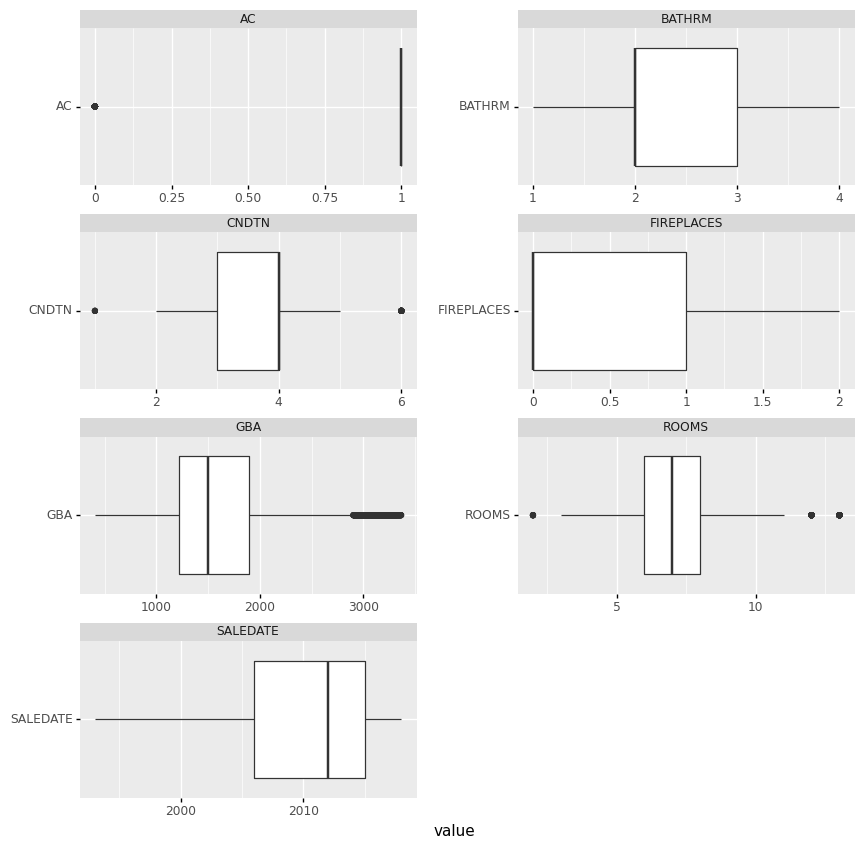

<ggplot: (300887179)>

In [10]:
# Visualize distributions of train_X
(
    ggplot(train_X.melt(),aes(x='variable',y='value')) +
    geom_boxplot() +
    coord_flip() +
    facet_wrap('variable',scales='free',ncol=2) +
    labs(x='') +
    theme(subplots_adjust={'wspace':0.3,'hspace':0.3},
          figure_size=(10,10))
)

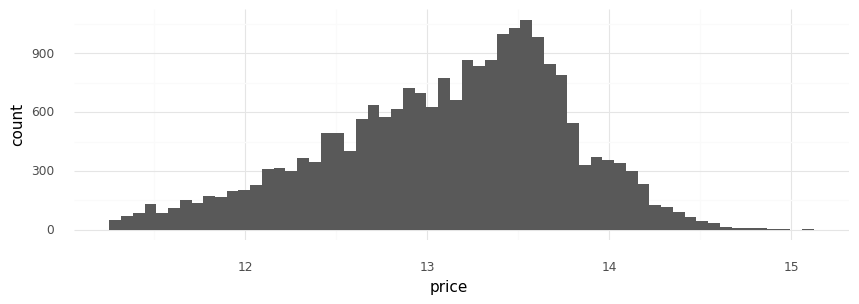

<ggplot: (301125226)>

In [11]:
# Visualize distributions of train_y
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x='price')) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (10,3))
)

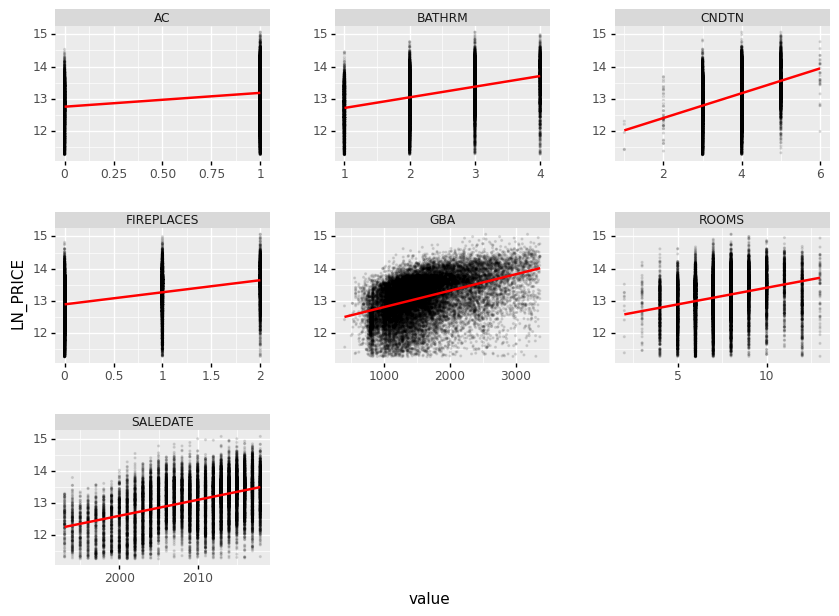

<ggplot: (301171499)>

In [12]:
# Visualize relationship between predictors and the outcome
(
    ggplot(train.melt(id_vars=['LN_PRICE']),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.1,size=0.3) +
    facet_wrap("variable",scales="free",ncol=3) +
    geom_smooth(method="lm",se=False,color="red") +
    theme(subplots_adjust={'wspace':0.3,'hspace':0.5},
          figure_size = (10,7)) 
)

## Pre-Processing

In [13]:
# Rescale the training data
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,AC,ROOMS,SALEDATE,GBA,CNDTN,FIREPLACES
0,0.666667,1.0,0.636364,0.96,0.288371,0.8,0.0
1,0.333333,1.0,0.636364,0.60,0.629817,0.4,0.5
2,0.333333,0.0,0.818182,0.88,0.854970,0.4,0.0
3,0.666667,1.0,0.454545,0.64,0.328262,0.6,0.5
4,0.666667,1.0,0.454545,0.92,0.441176,0.6,0.0
...,...,...,...,...,...,...,...
21968,0.000000,1.0,0.272727,0.96,0.191684,0.4,0.5
21969,0.333333,1.0,0.454545,0.96,0.404327,0.6,0.5
21970,0.333333,1.0,0.636364,0.32,0.679851,0.6,1.0
21971,0.666667,1.0,0.363636,0.76,0.349899,0.6,0.5


## Modeling
- Linear Regression 
- KNN
- Decision Tree
- Bagging 
- Random Forest

In [14]:
# Create a KFold generator
fold_generator = KFold(n_splits=5,shuffle=True,random_state=111)

# Set the performance metrics
use_metrics = ["neg_mean_squared_error"]

In [15]:
# Linear Model
lm_scores = cross_validate(LM(),train_X,train_y,cv=fold_generator,scoring=use_metrics)

# KNN
knn_scores = cross_validate(KNN(),train_X,train_y,cv=fold_generator,scoring=use_metrics)

# Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_y,cv=fold_generator,scoring=use_metrics)

# Bagging
bag_scores = cross_validate(Bag(),train_X,train_y,cv=fold_generator,scoring=use_metrics)

# Random Forest
rf_scores = cross_validate(RF(),train_X,train_y,cv=fold_generator,scoring=use_metrics)

In [16]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.188477
1,lm,0.185380
2,lm,0.189694
3,lm,0.180202
4,lm,0.197402
5,knn,0.185999
6,knn,0.190263
7,knn,0.190488
8,knn,0.182791
9,knn,0.193134


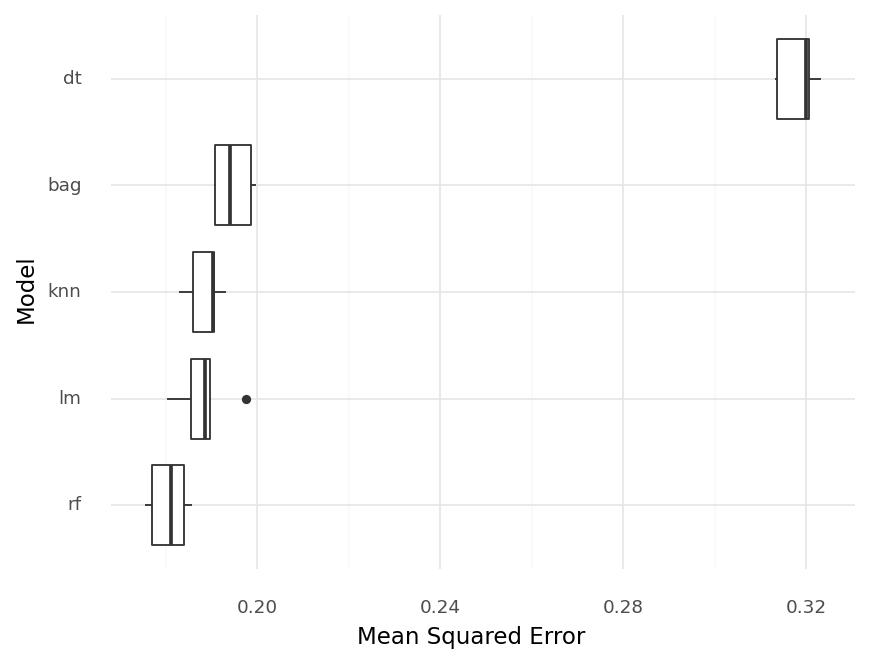

<ggplot: (302461995)>

In [17]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot to compare the models
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

The random forest model presents the best performance with the lowest mean squared error.

## Model Tuning

### KNN

In [18]:
# Report all the available tunning parameters for KNN
KNN().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [19]:
# Set the tunning parameters
knn_tune_params = {'n_neighbors':[5,10,25,50,100]}

In [20]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [5, 10, 25, 50, 100]},
             scoring='neg_mean_squared_error')

In [21]:
tune_knn.best_params_

{'n_neighbors': 25}

In [22]:
tune_knn.best_score_

-0.17062903742204844

### Decision Tree

In [23]:
# Report all the available tunning parameters for decision tree
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [24]:
# Set the tunning parameters
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [25]:
tune_dt.best_params_

{'max_depth': 7}

In [26]:
tune_dt.best_score_

-0.18078802680840383

### Random Forest

In [27]:
# Report all the available tunning parameters for random forest
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [28]:
# Set the tunning parameters
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
             'max_features':[1,3,5]}
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

tune_rf.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 3, 5],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [29]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 3, 'n_estimators': 1000}

In [30]:
tune_rf.best_score_

-0.21508028042182667

## Modeling Pipeline

In [32]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5,shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','AC','ROOMS','SALEDATE',
                                                                         'GBA','CNDTN','FIREPLACES'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[7,10,13,15]},
    
    # The Bagging decision tree model
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,3,5],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'AC',
                                                                          'ROOMS',
                                                                          'SALEDATE',
                                                                          'GBA',
                                                                          'CNDTN',
                                                                          'FIREPLACES'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [Li

In [33]:
search.best_score_

-0.17036575991324526

In [34]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

## Test Performance

In [41]:
# Read in the test dataset
test = pd.read_csv("../test_data.csv")

# Drop observations where logged price is zero
test = test[test["LN_PRICE"] != 0]

# Drop observations with NA values
test.dropna(inplace = True)

# Subset the test data to chosen features
test = test[['BATHRM','AC','ROOMS','SALEDATE','GBA','CNDTN','FIREPLACES','LN_PRICE']]

# Change Y/N in column AC to 1/0
test['AC'] = test.AC.map(dict(Y=1,N=0))
test.dropna(subset=['AC'],inplace=True)

# Convert column SALEDATE to datetime and keep only year
test['SALEDATE'] = pd.to_datetime(test['SALEDATE']).dt.year

# Calculate the interquartile range (IQR)
Q1 = test.quantile(0.25)
Q3 = test.quantile(0.75)
IQR = Q3 - Q1

# Drop the outliers
test = test[~((test[IQR_col] < (Q1 - 1.5 * IQR))|
              (test[IQR_col] > (Q3 + 1.5 * IQR)))
            .any(axis=1)]

# Split the test data
test_X = test[['BATHRM','AC','ROOMS','SALEDATE','GBA','CNDTN','FIREPLACES']]
test_y = test['LN_PRICE']

In [42]:
# Rescale the test data
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)

# Convert back into data frame
test_X = pd.DataFrame(test_X,columns=col_names)

In [43]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [44]:
m.mean_squared_error(test_y,pred_y)

0.17653513261679987

In [45]:
m.r2_score(test_y,pred_y)

0.5966528956872581

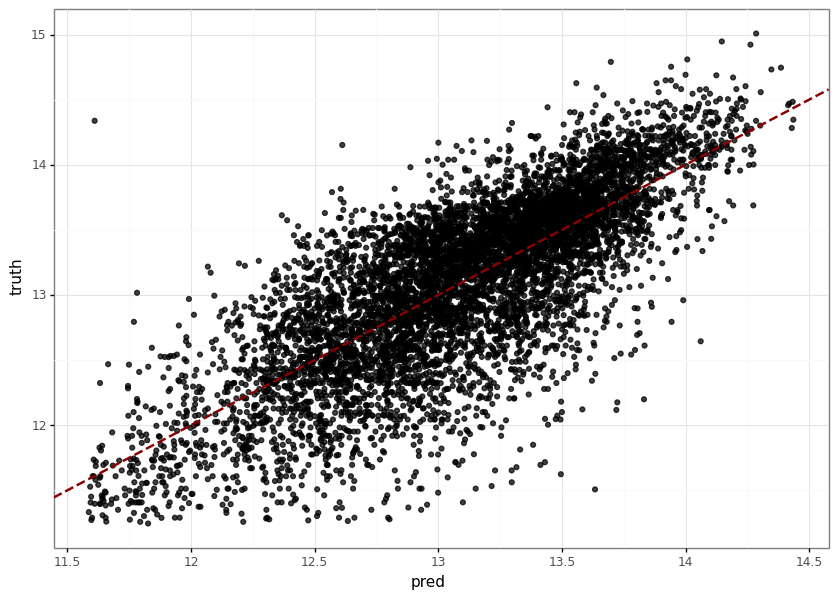

<ggplot: (304939587)>

In [46]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)